In [1]:
import os
import io
import cv2
import copy
import math
import random
import numpy as np
import pickle as pkl
from tqdm import tqdm, trange
from typing import Deque, Dict, List, Tuple
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split



## dataset

    Load dataset from your google drive.
    Please add a short cut of our dataset on google drive to your own google drive.
    Change the "main_path" of the dataset if necessary.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
paths = []
main_path = '/content/gdrive/My Drive/transitions/'
dirs = os.listdir(main_path)
dirs.sort()
for d in dirs:
    dirs1 = os.listdir(main_path+'/'+d)
    dirs1.sort()
    for p in dirs1:
      paths.append(main_path+'/'+d+'/'+p)
      # print(paths[-1])
print('%d episodes'%len(paths))


228 episodes


In [4]:
class MMDataset(Dataset):
    def __init__(self, paths):
        self.transitions = []

        for p in tqdm(paths):
            with open(p, "rb") as f:
                demo = pkl.load(f, encoding="bytes")
                self.transitions.extend(demo)
        
    def __getitem__(self,index):
        mm_scan = self.transitions[index][b'mm_scan']
        laser_scan = self.transitions[index][b'laser_scan']
        mm_scan = torch.Tensor(mm_scan).reshape(1,-1)
        laser_scan = torch.Tensor(laser_scan).reshape(1,-1)
        
        return mm_scan, laser_scan
    
    def __len__(self):
        return len(self.transitions)

    
batch_size = 16
mm_dataset = MMDataset(paths)

loader = DataLoader(dataset=mm_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=4)


100%|██████████| 228/228 [02:25<00:00,  1.57it/s]


## hyper parameters

In [5]:
hyper_parameter = dict(
    kernel=3,
    stride=2,
    padding=2,
    latent=128,
    deconv_dim=32,
    deconv_channel=128,
    adjust_linear=235,
    epoch=100,
    learning_rate=0.001,
)
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
config = Struct(**hyper_parameter)

## model

In [6]:
class MMvae(nn.Module):
    def __init__(self):
        super(MMvae, self).__init__()
        kernel = 3
        stride = 2
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=kernel, stride=stride),
            nn.ReLU()
        )
        
        dim = 64*59
        self.linear1=nn.Sequential(
            nn.Linear(dim,512),
            nn.ReLU()
        )
        self.en_fc1=nn.Linear(512,config.latent)
        self.en_fc2=nn.Linear(512,config.latent)
        
        self.de_fc1=nn.Sequential(
            nn.Linear(config.latent,config.deconv_channel*config.deconv_dim),
            nn.ReLU()
        )
        
        self.de_conv =nn.Sequential(
            nn.ConvTranspose1d(config.deconv_channel, config.deconv_channel//2, kernel, stride=stride, padding=config.padding),
#             nn.ReLU(),
            nn.ConvTranspose1d(config.deconv_channel//2, config.deconv_channel//4, kernel, stride=stride, padding=config.padding),
#             nn.ReLU(),
            nn.ConvTranspose1d(config.deconv_channel//4, 1, kernel, stride=stride, padding=config.padding),
#             nn.ReLU(),
        )
        self.adjust_linear=nn.Sequential(
            nn.Linear(config.adjust_linear,241),
            nn.ReLU()
        )

        
    def encoder(self,x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.linear1(x)
        mean = self.en_fc1(x)
        logvar = self.en_fc2(x)
        return mean, logvar

    def reparameter(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std

    def decoder(self,x):
        x = self.de_fc1(x)
        x = x.view(-1, config.deconv_channel, config.deconv_dim)
        x = self.de_conv(x)
        x = self.adjust_linear(x)
        return x

    def forward(self,x):
        mean, logvar = self.encoder(x)
        x = self.reparameter(mean, logvar)
        x = self.decoder(x)
        return x ,mean ,logvar

## load model

    Load model from your google drive.
    Please add a short cut of our inference model on google drive to your own google drive.
    Change the "model_path" of the dataset if necessary. 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device, ',device)
model = MMvae()
model.to(device)
model_path = '/content/gdrive/My Drive/deploy_model/vae/0726_1557.pth'
model.load_state_dict(torch.load(model_path))

device,  cuda:0


<All keys matched successfully>

## visualize examples

In [8]:
def laser_visual(lasers=[], show=False, range_limit=6):
    colors = ['#3483EB','#FFA500','#15B01D']
    fig = plt.figure(figsize=(8, 8))
    for i, l in enumerate(lasers):
        # fig = plt.figure(figsize=(8, 8))
        angle = 120
        xp = []
        yp = []
        for r in l:
            if r <= range_limit:
                yp.append(r * math.cos(math.radians(angle)))
                xp.append(r * math.sin(math.radians(angle)))
            angle -= 1
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        # plt.axis('off')
        plt.plot(xp, yp, 'x', color=colors[i])
    plt.show()


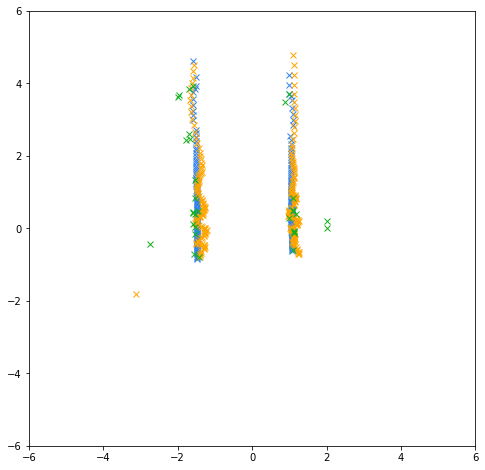

In [9]:
data1 = None
for mm_scan, laser_scan in loader:
    mm_scan = mm_scan.to(device)
    
    x_hat ,mean ,logvar = model(mm_scan)
    
    x = x_hat.detach().cpu().numpy().reshape(batch_size,-1)[0]
    laser = laser_scan.numpy().reshape(batch_size,-1)[0]
    mm = mm_scan.detach().cpu().numpy().reshape(batch_size,-1)[0]
    
    laser_visual([laser, x, mm], show=True, range_limit=4.9)
    data1 = [laser, x, mm]
    break